## Flexible Interface

Previously we have shown a couple of examples of how to use `sbi` package as a one-liner. Here we are going to show the flexible interface of the package, which might be useful for customizing the code to fit a particular problem

Within this block we are going to discuss:

- performing sequential posterior estimation by focusing on a particular observation over multiple rounds. This may decrease the number of simulations one has to run or simpy improve the inference results, but the inference procedure is no longer amortized .    
- possibly specify your own density estimator, or change hyperparameters of existing ones (e.g. number of hidden units for [NSF](https://arxiv.org/abs/1906.04032)).    
- methods of crafting summary statistics instead of using the whole simulation as an input to neural network
- parallelisation over multiple workers on the same node or multiple nodes

## Real Life example

Below is actually a very basic example from my own research. This is an epidemiological model of the first 70 days of the COVID-19 pandemic starting from the beginning of March until the end of May and is a good illustration of how summary statistic can influence the inference results.

We will implement a version of SEIR model (Susceptible-Exposed-Infected-Recovered) and will use `pyross` package for that

We do the necessary imports first

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import pyross
import torch
from sbi.analysis.plot import pairplot
from sbi.inference import SNPE, simulate_for_sbi
import sbi.utils as utils

## RKI data

Again, not to overload our example with additional RKI software we pass the pre-downloaded RKI data on the incidence rates as a dicitonary. Further on, we pass it to the class `CaseData` defined above and get the input ready for SBI implementation.

In [2]:
data= pd.read_csv("../data/RKI_data.csv")
data

,Date,Confirmed,Deaths,Recovered
0,2020-03-01,1902.428571,43.000000,1859.428571
1,2020-03-02,2206.571429,50.142857,2156.428571
2,2020-03-03,2575.857143,59.428571,2516.428571
3,2020-03-04,3034.714286,71.571429,2963.142857
4,2020-03-05,3619.000000,86.285714,3532.714286
...,...,...,...,...
87,2020-05-27,182183.428571,9123.714286,173059.714286
88,2020-05-28,182602.000000,9132.285714,173469.714286
89,2020-05-29,182989.714286,9140.428571,173849.285714
90,2020-05-30,183346.142857,9147.428571,174198.714286


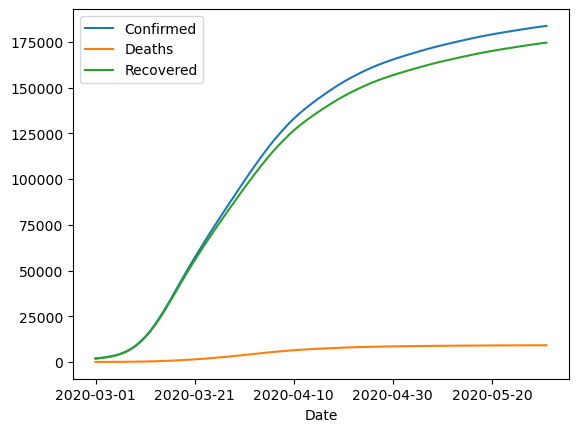

In [3]:
data.plot(x="Date", y=['Confirmed', 'Deaths', 'Recovered'])
plt.show()

## The SEIR model and the simulator

The simulator below is implementing the following SEIR model

$
\frac{dS}{dt}=-\beta SI
$

$
\frac{dE}{dt}= \beta SI - \alpha E
$

$
\frac{dI}{dt}= \alpha E -\gamma I
$

$
\frac{dR}{dt}= \gamma I
$

$S+E+I+R=N$

$
\beta = 
\begin{cases} 
\beta_1 & \text{if } t<T \\
\beta_2 & \text{if } t\geq T \\
\end{cases}
$

Here, $S$ the number of people susceptible to the infection in the population on day $t$, $E$ the number of people exposed to the virus on day $t$, $I$ the number of people who has the infection on day $t$, $R$ is the number of people who recovered from the infection as of day $t$

Parameter $\beta$ is the infection rate. Note, that we are modeling a change-point at timepoint $T=18$. This way we are taking into account massive non-pharmaceutical interventions which were undertaken around March, 18, 2020. This corresponds to variables `beta`, `beta_1`, `beta_2` in the code.

Parameter $\alpha$ (`gE` in the code) is the transition rate from Exposed to Infected. This is the unobserved parameter and in our code for simplicity it is set to a constant $0.85$.

Parameter $\gamma$ (`gI` in the code) is the recovery rate. 

All the compartments sum up to the total population $N$ which we assume to be $10^6$ in the simulator below.

Importantly, to make our system of ODE complete, we need to pass the initial values for the compartments $S$, $E$, $I$, $R$, which are $S_0$, $E_0$, $I_0$, $R_0$ respectovely. Our simulator assumes fixed values for each one of them, but of course, especially those for unobserved compartments such as $E$ and partly $S$, can also be passed as parameters of the model. 

## Parametrisation

Note that our simulator has three parameters related to infection rate and recovery rate. However, the parametrisation is not exactly straightforward. Since SBI is learning from the large number of the unconstrained simulations, we want to utilise all the prior information available. This, being dependence between parameters $\beta_1$, $\beta_2$ and $\gamma$. 

Firstly, given that on March 18, 2020 there was a non-pharmaceutica intervention, seriously limiting contacts between people, we expect that infection rate $\beta_2$ should most likely be smaller than $\beta_1$. Therefore, while the simulator function `simulator2` takes $\beta_1$ as the first parameter, the second parameter is modelling the difference between $\beta_2$ and $\beta_1$, at the same time not allowing $\beta_2$ to become negative. 

We apply a similar procedure to the recovery rate. Given the need for a non-pharmaceutical intervention, we assume that the recovery rate $\gamma$ was most likely lower than the initial infection rate $\beta_1$ and, again, the third parameter of the simulator is modelling the difference between $\gamma$ and $\beta_1$ in a similar fashion to the precious case. 

## Pyross package

Package `pyross` is a specific package for simulating epidemiological scenarios through compartmental models (https://pyross.readthedocs.io/en/latest/). It provides an easy interface of specifying our $SEIR$ model given the parameters and adding some randomness to it.

## Data

Importantly, if we intend to fit our model to the observed data, we need to make sure that the output of the simulator conceptually corresponds to the RKI data we have just downloaded. Given the parameters $\beta_1$, $\beta_2$, $\alpha$, $\gamma$, $S_0$, $E_0$, $I_0$, $R_0$ (or $N$), the output of the model will be the trajectories of $S$, $E$, $I$, $R$ over the specified time period.

However, unfortunately, the RKI data do not exactly correspond to any one of these compartments. The most objective data we have is daily "Daily confirmed infections", which is essentially the number of the individuals who were in the infected compartment at any point up to this particular date. Therefore, in order for our simulator to output exactly the data corresponding to our real data, we need to sum up the Infected and Recovered compartments (all people who are infected now and were before). You can see this being performed as the final step within the `simulator2` function

In [4]:
def simulator2(parameters):
    M = 1  # the population has one age group
    N = 1e6  # and this is the total population
    Ni = N * np.ones(M)

    parameters=parameters.reshape((3,))

    beta1 = np.array(parameters[0])  # initial infection rate

    beta2 = np.max((beta1+np.array(parameters[1]),0.0001)) # infection rate after an NPI

    gE = 0.85  # transition from E to I

    gI = np.max((beta1+np.array(parameters[2]),0.0001)) # recovery rate 

    # set up initial conditions

    E0 = 3000 
    I0 = 1900
    R0 = 0
    S0 = N - (E0 + I0 + R0)

    #for pyross

    x0 = {"S": [S0], "E": [E0], "I": [I0], "R": [R0]}

    Tf = 70  # time span of our model
    Nf = Tf + 1

    # set the contact structure
    def contactMatrix(t):
        # C_ij = number of people group from group i that an individual from group j meets per day
        C=np.eye(M)
        return C


    #pyross model specification

    parameters = {"beta1": beta1,"beta2":beta2, "gE": gE, "gI": gI}
    true_parameters = {"beta1": beta1,"beta2":beta2, "gE": gE, "gI": gI}


    model_spec = {
        "classes": ["S", "E", "I", "R"],
        "S": {
            "infection": [["I", "S", "-beta"]],
        },
        "E": {"linear": [["E", "-gE"]], "infection": [["I", "S", "beta"]]},
        "I": {
            "linear": [
                ["E", "gE"],
                ["I", "-gI"],
            ],
        },
        "R": {
            "linear": [["I", "gI"]],
        },
    }

    # define time dependent parameters, in our case beta, which takes value beta1 before timepoint T and beta2 after timepoint T

    def parameter_mapping(input_parameters, t):
        output_parameters = {
            'gE' : input_parameters['gE'] ,
            'gI' : input_parameters['gI'] 
        }
        if t<18:
            output_parameters['beta'] = input_parameters['beta1']
        else:
            output_parameters['beta'] = input_parameters['beta2']
        return output_parameters


    # generating stochastic trajectory with pyross

    sto_model = pyross.stochastic.Model(model_spec, true_parameters, M, Ni,time_dep_param_mapping=parameter_mapping)

    # simulate model

    data = sto_model.simulate(x0, contactMatrix, Tf, Nf, method="tau-leaping")
    
    # record the outputs

    data_array = data["X"]

    # make the outputs look similar to the observed data

    data_array=data_array[:,2]+data_array[:,3]

    data_array=torch.from_numpy(data_array)

    return data_array

## Specifying the prior distributions

We use uniform distributions as our priors and specify their ranges according to the assumptions on $\beta_1$ and $\gamma$ discussed previously. Since the second and the third parameters model the difference between $\beta_2$ and $\beta_1$, and $\gamma$ and $\beta_1$, the corresponding ranges of the Uniform distributions are biased towards negative values, although we certainly allow a possibility of those differences being positive as well.

`BoxUniform` prior is a built-in function of the `sbi` package.

In [5]:
lower_limits_prior = torch.tensor([0.8,-0.3,-0.3])
upper_limits_prior = torch.tensor([1.5, 0.1,0.1])
prior_cpu = utils.BoxUniform(
    low=lower_limits_prior,
    high=upper_limits_prior
)

## Preparing what to expect

Before we start our inference we often want to get a feel of how the prior we chose influence the outputs of the simulator and how the outputs of the simulator relate to our datapoints.

The code below draws a number of parameter samples from the prior distribution above and plots the corresponding output trajectories as computed by the `simulator2` function (grey). Then it plots the actual data trajectory on top of them (black).

Looking at the trajectories, we can say, that they can be really off (i.e. lie really far away from the data), however the range is large enough to be confident that there are those ones close to the ground truth. So overall it would be reasonable to proceed with the given simulator and the chosen prior distributions.

  0%|          | 0/100 [00:00<?, ?it/s]

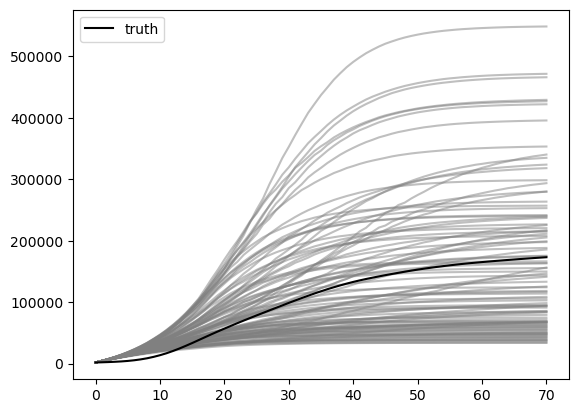

In [6]:
%matplotlib inline
y_truth=np.asarray(data.Confirmed)[0:71]
plt.plot(y_truth, "k", zorder=1, label="truth")

num_sims = 100
params, y_ = simulate_for_sbi(simulator2, proposal=prior_cpu, num_simulations=num_sims, num_workers=50)
y_ = y_.reshape(num_sims,len(y_truth)).T
plt.plot(y_, "grey", zorder=0,alpha=0.5)
plt.legend()
plt.show()

There are auxiliary functions which are supposed to make sure the components of the SBI have the appropriate format. We will omit them for now

In [ ]:
# from sbi.utils.user_input_checks import (
#     check_sbi_inputs,
#     process_prior,
#     process_simulator,
# )
# prior, num_parameters, prior_returns_numpy = process_prior(prior_cpu)
# simulator = process_simulator(simulator2, prior_cpu, prior_returns_numpy)
# check_sbi_inputs(simulator, prior_cpu)

### Putting priors on the correct devices

We will need to run the simulations on the CPU, whilst the neural network training is going to be done on the GPU, if available. For this we will create another instance of prior, `prior_gpu`.

In [9]:
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
prior.to(device)

## Instantiating the inference object

In order instantiate the inference object call one of the functions `SNPE`, `SNRE`, `SNLE` from `sbi.inference`.

 Note, that we can also customize the density estimator, namely the neural network used to build an approximate posterior/likelihood/likelihood ratio. More information on the available networks can be found in `sbi/utils/get_nn_models.py`. It is also possible to implement your own density estimator from scratch, e.g., including embedding nets to preprocess data, or to a density estimator architecture of your choice. 

For this, the `density_estimator` argument needs to be a function that takes `theta` and `x` batches as arguments to then construct the density estimator after the first set of simulations was generated.

The default value for the `density_estimator` is `maf`, whic h corresponds to Masked Autoregressive Flow, a normalizing flow which models the target distribution density as a product of conditional distribution densities $p(x_i|x_{1:i-1})$, where $\{x_i\}_{i=1}^n$ are the variables (hence autoregressive). MAF is applies linear transformations to the variables.

Certainly, there is an option of replacing the default value `maf` (mean autoregressive flow) for `density_estimator` with `nsf` (neural spline flow). Neural Spline Flow, unlike MAF is a flow which performs non-linear (quadratic) transformations over variables. It takes longer to train such a network, and it is not always beneficial.

You can uncomment the line where `SNPE` explicitly specifies `density_estimator` and see for yourself, how the inference changes. Spoiler: in this particular example training drastically slows down, and the inferred posterior turns out to be a rather poor fit for the data, as will be seen from the posterior sampling procedure.

Going into finer details there is also an option of configuring the density estimator choosing the number of hidden features, transforms etc.  More details on hyperparameters can be found at `sbi/neural_nets` 
`

In [34]:
from sbi.neural_nets import posterior_nn # For SNLE: likelihood_nn(). For SNRE: classifier_nn()

density_estimator_build_fun = posterior_nn(
    model="nsf", hidden_features=30, num_transforms=4
)

#inference = SNPE(prior=prior, density_estimator=density_estimator_build_fun,device=device)

prior.to(device)
inference=SNPE(prior=prior,device=device)

## Running the actual simulations

Next, the simulations are run. In this case it is done with a helper function provided by `sbi` called `simulate_for_sbi`. This function allows to parallelize the code with `joblib` by passing the parameter `num_workers` (value `-1` indicates usage of all resources available). This will distribute the simulation over multiple cpus within one node. Later, we will talk about distributing simulations over multiple nodes. For that one would need to use a `ray` backend within `joblib`.

In [28]:
num_sims = 1000
prior.to("cpu")
theta, x = simulate_for_sbi(simulator2,
                            proposal=prior,
                            num_simulations=num_sims,
                            num_workers=20)

  0%|          | 0/1000 [00:00<?, ?it/s]

The simulated data are then passed to the inference object.  `theta` and `x` should both be a `torch.Tensor` of type `float32`. We also need to ensure `x` has the right shap for our training: `(num_sims,output_sim_dim)`.

In [35]:
x=x.reshape((num_sims,71))
x=np.float32(x)
x=torch.from_numpy(x)
inference = inference.append_simulations(theta.to(device), x.to(device))

The density estimator is then trained

In [36]:
density_estimator = inference.train()

 Neural network successfully converged after 380 epochs.

Lastly, the density estimator can be used to build the posterior:

In [37]:
posterior = inference.build_posterior(density_estimator)

## Posterior inference

From this point onwards we perform all the same steps as before for drawing inference from an observation. We define our observation, which corresponds to the cumulative COVID-19 cases first 70 days of the pandemic

In [38]:
y_o=np.asarray(data.Confirmed)[:71]
y_o=torch.from_numpy(y_o)

What sampling from the posterior actually does, along with sampling from the inferred distribution, is direct posterior sampling, i.e. making sure that the samples are within the support of the prior. If too few samples are accepted, you will get a corresponding warning as well as a suggestion to change the sampling algorithm to MCMC (test it passing the `nsf` as a density estimator)

In [39]:
posterior.to("cpu")
samples = posterior.sample((10000,), x=y_o)

Drawing 10000 posterior samples for 1 observations:   0%|          | 0/10000 [00:00<?, ?it/s]

## Visualising the results

The plots below visualise the inferred distributions of the parameters both in 1D and 2D projections.

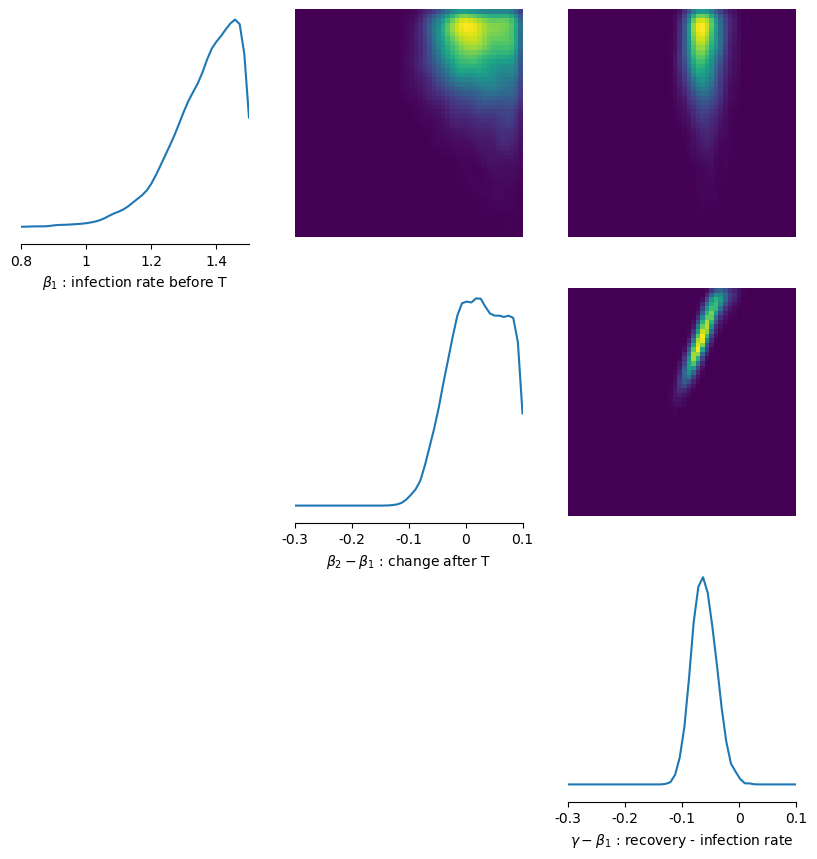

In [40]:
limits = torch.stack([lower_limits_prior,upper_limits_prior]).T
fig, out = pairplot(samples.detach().cpu().numpy(), limits=limits,
                    labels=[r"$\beta_1$ : infection rate before T",
                            r"$\beta_2 - \beta_1$ : change after T",
                            r"$\gamma - \beta_1$ : recovery - infection rate"],
                    fig_kwargs={'fig_size':(3,3)},
                    upper='kde',
                    diag='kde')

## Sanity check

Let us now do a simple sanity check. We take the mean of the posterior parameter samples corresponding to each one of the models (with MSE and without MSE), simulate a data trajectory according to the mean values of the parameters, and compare it to the RKI data.

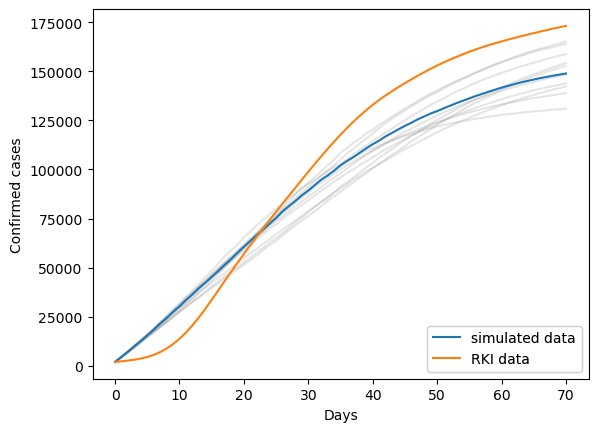

In [41]:
samples_ave=torch.unsqueeze(torch.mean(samples,axis=0),0)
samples_ave=samples_ave.detach().cpu()

observation=simulator2(samples_ave)

fig,ax=plt.subplots()

line1,=ax.plot(observation.detach().cpu(),label="simulated data")

# import multiprocessing
# with multiprocessing.Pool() as pool:
y_=list(map(simulator2, samples[:10].cpu()))

y_=torch.stack(y_)
y_=np.asarray(y_)

plt.plot(y_.T, "grey", zorder=0,alpha=0.2)

#line2,=ax.plot(observation1,label="simulated data no MSE")
line3,=ax.plot(data.Confirmed[0:71],label="RKI data")
first_legend = ax.legend(handles=[line1,line3], loc='lower right')
ax.add_artist(first_legend)
plt.xlabel("Days")
# plt.ylim(0,200000)
plt.ylabel("Confirmed cases")
plt.show()

# Sequential inference

Now let us see how our results change if we use sequential inference instead of the amortized one. We choose to do it in two rounds an use the same observation in both. As running 10000 simulations takes a fair amount of time, I recommend starting with 5000 (Spoiler: if you run 10000, this will significantly improe the fit)

Note, that given that we are running the simulations and network training on different devices, it gets a bit tricky with moving things around. 

Network training results in posterior distribution which is then in the second round of inference is used as a new prior distribution. Hence, before it is passed to the simulator (defined on the CPU), we have to move it from the GPU. We do it with auxiliary `inference1_cpu` object. Note, that `append_simulations` does not influence the corresponding class in connection to building the posterior distribution, and hence this move is justified.

In [42]:
num_rounds = 2
# The specific observation we want to focus the inference on.

posteriors = []
proposal = prior_cpu
#inference = SNPE(prior=prior, density_estimator="nsf")
inference1=SNPE(prior=prior,device=device)
inference1_cpu=SNPE(prior=prior_cpu,device='cpu')
num_sims_sequential = int(num_sims/2.0)
for _ in range(num_rounds):
    #proposal=proposal.to('cpu')
    theta1, x1 = simulate_for_sbi(simulator2, proposal, num_simulations=num_sims_sequential,num_workers=-1)
    x1=x1.reshape((num_sims_sequential,71))
    x1=x1.to(torch.float32)
    # In `SNLE` and `SNRE`, you should not pass the `proposal` to `.append_simulations()`
    density_estimator = inference1.append_simulations(
        theta1, x1, proposal=proposal
    ).train()
    density_estimator=density_estimator.to('cpu')
    #inference1=inference1.to('cpu')
    posterior1 = inference1_cpu.build_posterior(density_estimator)
    #posterior1=posterior1.to('cpu')
    proposal = posterior1.set_default_x(y_o)

  0%|          | 0/500 [00:00<?, ?it/s]

/p/project1/training2506/sbi_env/sbi_iscb25_venv/lib/python3.11/site-packages/sbi/inference/trainers/npe/npe_base.py:158: UserWarning: Data x has device 'cpu'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
/p/project1/training2506/sbi_env/sbi_iscb25_venv/lib/python3.11/site-packages/sbi/inference/trainers/npe/npe_base.py:187: UserWarning: The proposal you passed is neither the prior nor a `NeuralPosterior` object. If you are an expert user and did so for research purposes, this is fine. If not, you might be doing something wrong: feel free to create an issue on Github.
  self._check_proposal(proposal)


Using SNPE-C with atomic loss
 Neural network successfully converged after 96 epochs.

Drawing 500 posterior samples for 1 observations:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 58 epochs.

The usual visualisation

Drawing 1000 posterior samples for 1 observations:   0%|          | 0/1000 [00:00<?, ?it/s]

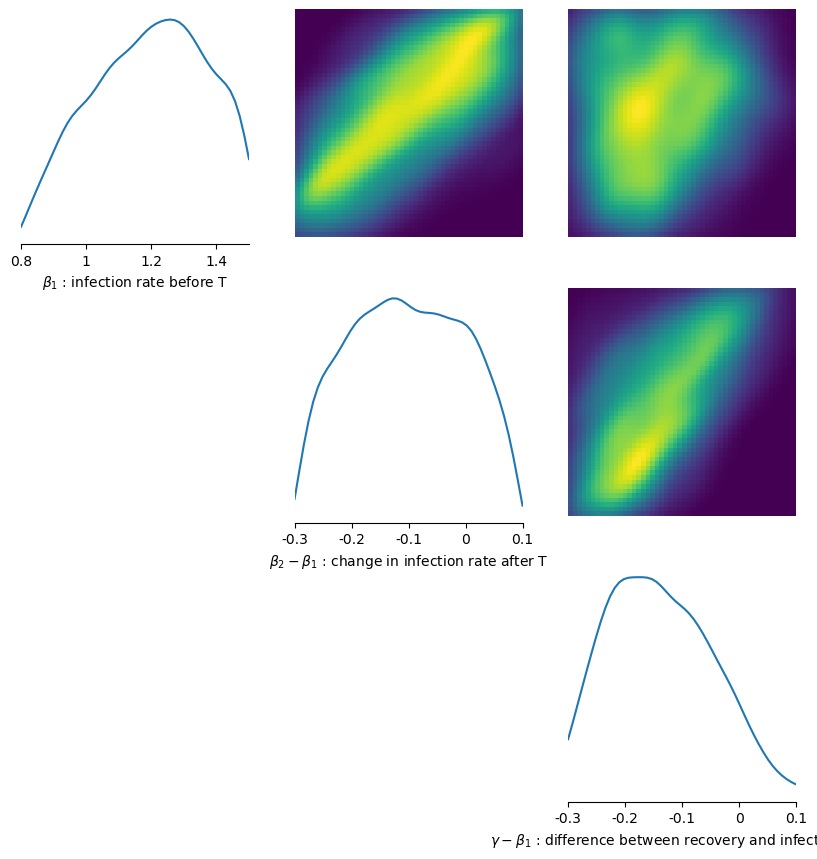

In [43]:
samples_sequential = posterior1.sample((num_sims,), x=y_o)
fig, out = pairplot(samples_sequential.detach().cpu().numpy(), limits=limits,
                    labels=[r"$\beta_1$ : infection rate before T", r"$\beta_2 - \beta_1$ : change in infection rate after T", r"$\gamma - \beta_1$ : difference between recovery and infection rate"],
                    fig_kwargs={'fig_size':(3,3)},
                    upper='kde',
                    diag='kde')

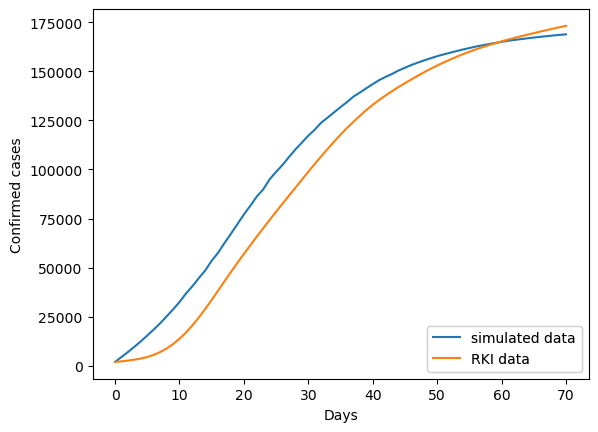

In [44]:
observation=simulator2(torch.unsqueeze(torch.mean(samples_sequential,axis=0),0))

fig,ax=plt.subplots()

line1,=ax.plot(observation,label="simulated data")
line3,=ax.plot(data.Confirmed[0:71],label="RKI data")
first_legend = ax.legend(handles=[line1,line3], loc='lower right')
ax.add_artist(first_legend)
plt.xlabel("Days")
plt.ylabel("Confirmed cases")
plt.show()

## learn from Summary Statistics

Now let us talk about summary statistic. Previously we have been extracting summary statistic from the simulation data without taking into the account the actual datapoint. However, this is clearly not forbidden!

Below we define a summary statistic which computes the mean squared error between the simulation output and the ground truth.

Note, that this kind of strategy can certainly work if you believe that all your datapoint correspond to a model with the same parameter values. However, if you want to run the SBI inference with the same prior on multiple datapoints, each one with possibly different parameter values, this approach may not work.

In [45]:
x=x.reshape((num_sims,71))

y_truth=np.asarray(data.Confirmed)[:71]

def get_MSE_sim(x,y_t):
    x=np.asarray(x)
    y_t=y_t.reshape((1,y_t.shape[0]))
    return np.mean(np.square(x - y_t),axis=1,keepdims=True)

x_summary=get_MSE_sim(x,y_truth)

## Specifying and training the model

Here we define the model (SNPE in our case) and train the neural network

In [46]:
x_summary=np.float32(x_summary)
x_summary=torch.from_numpy(x_summary).to(device)

inference=SNPE(prior, device=device)

_ = inference.append_simulations(theta, x_summary).train(training_batch_size=1000)

posterior = inference.build_posterior()

 Neural network successfully converged after 732 epochs.

## Incorporating the datapoint and visualising the results

Since we have already specified our datapoint when computing the summary statistic, in order to run the inference on the same data point we pass the variable `y_truth` as 0. We sample from the posterior and visualise the distributions of our parameters.

Drawing 10000 posterior samples for 1 observations:   0%|          | 0/10000 [00:00<?, ?it/s]

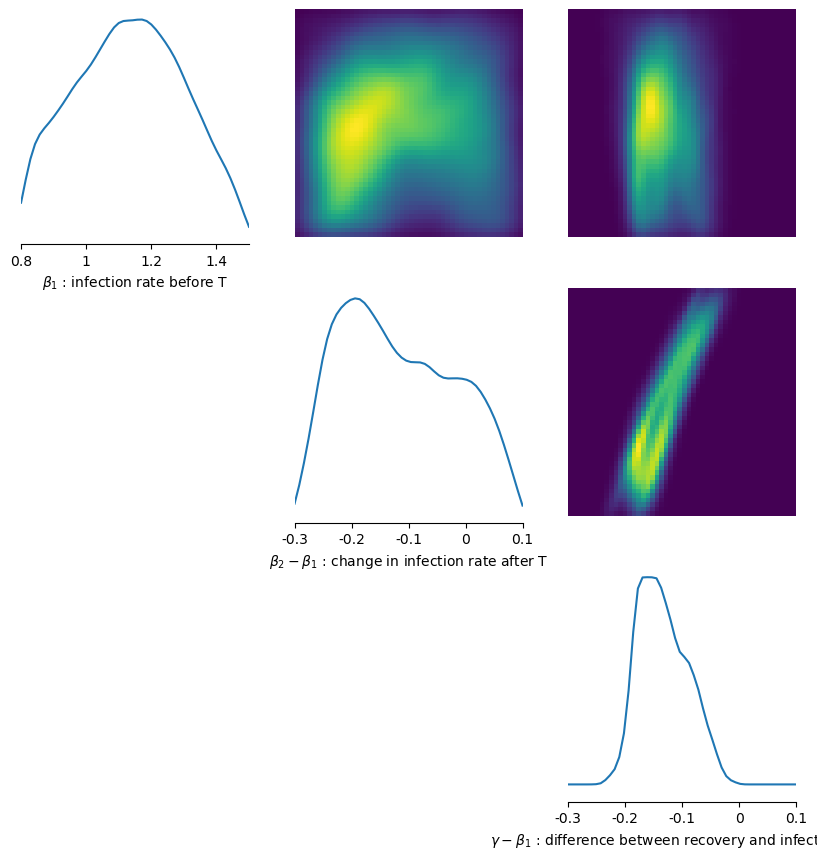

In [47]:
y_truth= torch.as_tensor(
    [
        [
            0.0,
        ]
    ]
).to(device)



theta_p = posterior.sample((10000,), x=y_truth)

fig, out = pairplot(theta_p.cpu(), 
                    limits=limits,
                    labels=[r"$\beta_1$ : infection rate before T", r"$\beta_2 - \beta_1$ : change in infection rate after T", r"$\gamma - \beta_1$ : recovery - infection rate"],
                    fig_kwargs={'fig_size':(3,3)},
                    upper='kde',
                    diag='kde')

## Comparing the results

Let us now do a simple sanity check. We take the mean of the posterior parameter samples corresponding to each one of the models (with MSE and without MSE), simulate a data trajectory according to each one of them, and compare the to the RKI data.

Clearly the trajectory with summary statistic looks better. You can increase the numer of simulations and see whether this will improve the inference in any one of the cases.

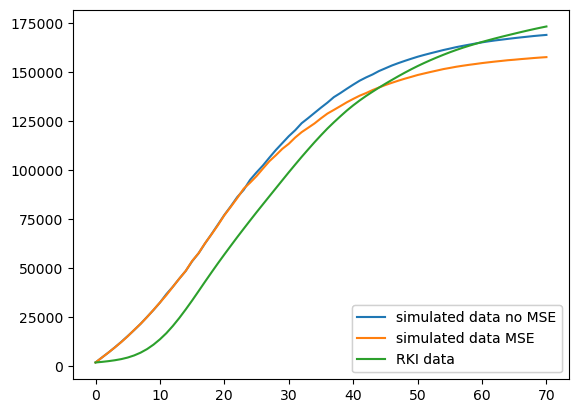

In [48]:
observation1=simulator2(torch.unsqueeze(torch.mean(theta_p.detach().cpu(),axis=0),0))

fig,ax=plt.subplots()

line1,=ax.plot(observation,label="simulated data no MSE")
line2,=ax.plot(observation1,label="simulated data MSE")
line3,=ax.plot(data.Confirmed[0:71],label="RKI data")
first_legend = ax.legend(handles=[line1,line2,line3], loc='lower right')
ax.add_artist(first_legend)
plt.show()

# How to distribute to multiple nodes?

Use ray cluster (read [getting started with ray](https://docs.ray.io/en/latest/cluster/getting-started.html)) for that!

The `sbi` package needs a slight modification to be parallelized with `ray` as backend. We provide two solutions to this problem.

One option is to use a modified version of the `simulate_for_sbi` function and the other is to modify the `sbi` source file `sbi/simulators/simutils.py` of your current `sbi` package installation.  

Afterwards, you may use use a batch script specific to ray clusters:  [documentation for slurm headers in ray](https://docs.ray.io/en/latest/cluster/vms/user-guides/community/slurm.html#ray-slurm-headers).
We provide a batch script which works on our system under `multi_node_ray/run_ray.sbatch`

### Use a patched version of `simulate_for_sbi`
In the `multi_node_ray` folder you will find the `sbi_patch.py` file, which has the modified `simulate_for_sbi` function. 

In your code, you may replace 

```python 
from sbi.utils.simulation_utils import simulate_for_sbi
```
with 
```python
from sbi_patch import simulate_for_sbi
```

having the `sbi_patch.py` file in your python path or in your local folder. The `pyross_example_script.py` already has this modification an runs in th JSC HPC clusters, using the `sbi_env` environment. An `sbatch` file is provided as an example, which needs small modifications to run on your JSC user account (see the slurm header).

### Modify sbi package option

Another option would be to perform these changes directly in your installation of the `sbi` package. 

Wrap the lines

```python
simulation_outputs = Parallel(n_jobs=num_workers)(
    delayed(simulator_seeded)(batch, batch_seed)
    for batch, batch_seed in zip(batches, batch_seeds)
    )
```

with 

```python
from ray.util.joblib import register_ray

register_ray()

with joblib.parallel_backend('ray'):
    simulation_outputs = Parallel(n_jobs=num_workers)(
        delayed(simulator_seeded)(batch, batch_seed)
        for batch, batch_seed in zip(batches, batch_seeds)
        )
```